The following code comes from [this site](https://colab.research.google.com/github/tensorflow/examples/blob/master/community/en/r1/deepdream.ipynb) but is translated from tensorflow to keras.

In [2]:
# for starters, let's get some functions for getting a specific filter from a specific layer.

import time
import numpy as np
from PIL import Image as pil_image
from keras.preprocessing.image import save_img
from keras import layers
from keras.applications import inception_v3
from keras import backend as K

import matplotlib.pyplot as plt
from IPython.display import clear_output, Image, display

# build the inception v3 network with ImageNet weights
inception = inception_v3.InceptionV3(weights='imagenet', include_top=False)
print('Model loaded.')
inception.summary()



Using TensorFlow backend.
/home/joe/tf-gpu-1.13/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/joe/tf-gpu-1.13/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/joe/tf-gpu-1.13/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/joe/tf-gpu-1.13/lib/python3.6/site-packages/tensorflo



Model loaded.
Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
_______________________________________________________________________

In [12]:
# util function to convert a tensor into a valid image
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8', casting='unsafe')
    return x

def step(model, output_layer, filter_index, img):
    # calculate L_1 loss
    loss = K.mean(output_layer.output[:, :, :, filter_index])

    # make gradients
    grads = K.gradients(loss, model.inputs[0])[0]
#    grads =  grads / (K.sqrt(K.mean(K.square(grads))) + K.epsilon())

    grads /= (K.std(grads) + K.epsilon())
    step = K.function([model.inputs[0]], [loss, grads])

    return step([img])
    
def get_layer_by_name(model, layer_name):
    # use model.summary to see the layer names.
    layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])

    if layer_name in layer_dict:
        return layer_dict[layer_name]
    else: return None

def get_random_filter(model, layer):
    # get a filter from model
    filter_upper = len(layer.get_weights()[1])

    assert(filter_upper > 0)

    # pick a random filter index
    return np.random.randint(filter_upper)

# Run `step(...)` iter times
def iterate_grads(model, outputLayer, index, iterations, inputImage):
    img = inputImage
    for _ in range(iterations):
        # output loss from one step
        loss, gradients = step(model, outputLayer, index, img)
        #print(gradients.shape)

        img = img + gradients
    return img

# What about with a picture instead of a random input?
from imageio import imread

def minmax_deprocess(image):
    maximum = float(image.max())
    minimum = float(image.min())
    
    # clip [0,1]
    scaled = (image - minimum)/float(maximum-minimum)
    
    # rescale to [0,255]
    new_image = scaled * 255
    return new_image.astype('uint8')

def norm_deprocess(image, s=0.1):
    return (image-image.mean())/max(image.std(), 1e-4) * s + 0.5
    

    

In [16]:
layer = get_layer_by_name(inception, 'conv2d_94')
idx = 139
#idx = 14

## create an image for the input.
input_img_data = np.random.random((1, 200, 200, 3))

image1 = iterate_grads(inception,  layer, idx, 30, input_img_data)


/home/joe/tf-gpu-1.13/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  import sys


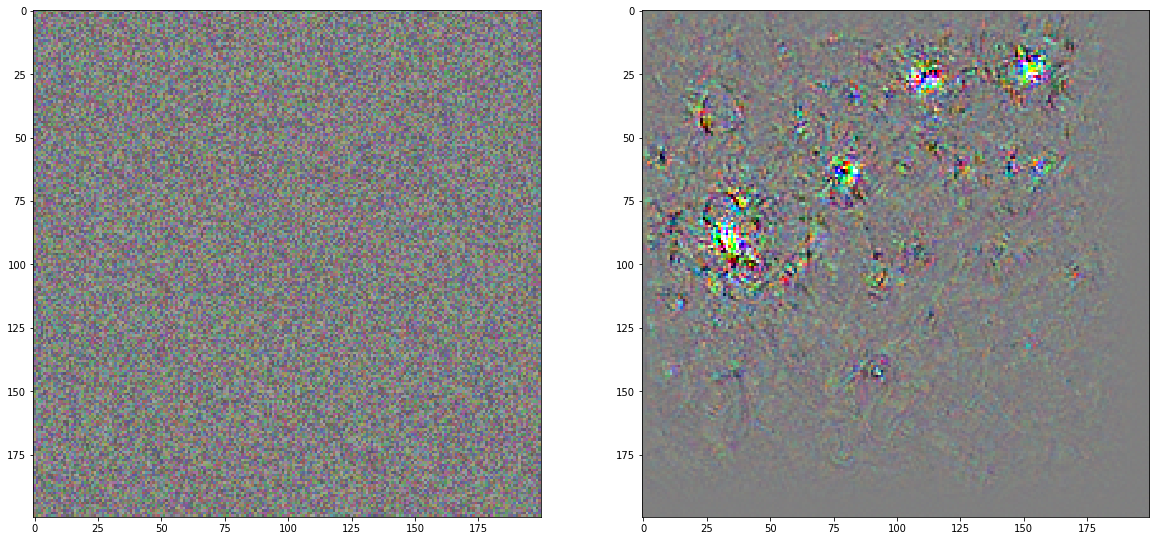

In [14]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20, 10))


ax1.imshow(deprocess_image(input_img_data.reshape(200,200,3)))
ax2.imshow(deprocess_image(image1.reshape(200,200,3)))

fig.show()


/home/joe/tf-gpu-1.13/lib/python3.6/site-packages/ipykernel_launcher.py:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  import sys


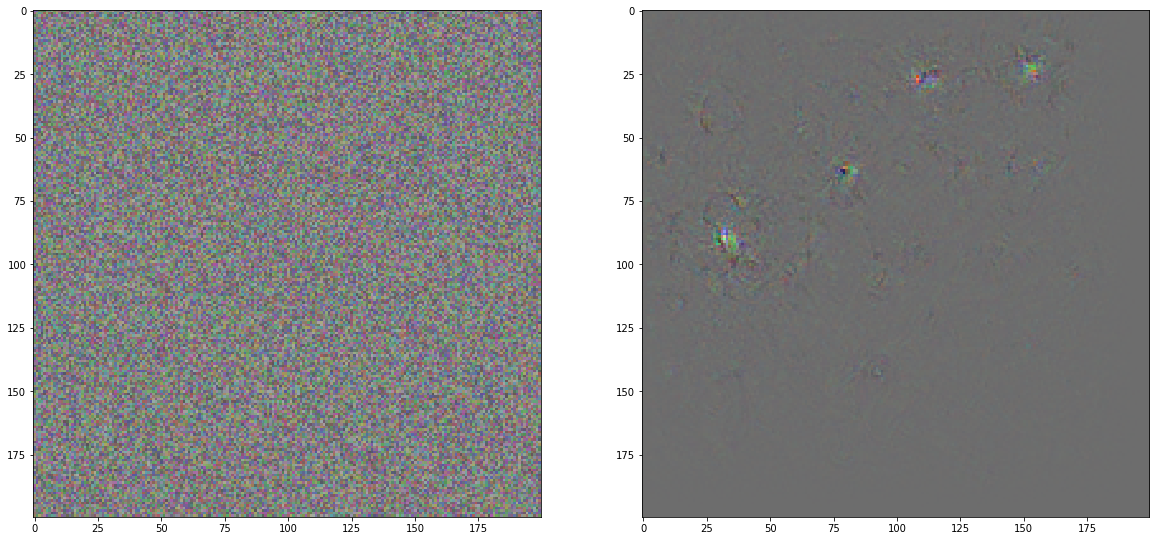

In [15]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20, 10))


ax1.imshow(deprocess_image(input_img_data.reshape(200,200,3)))
ax2.imshow(minmax_deprocess(image1.reshape(200,200,3)))

fig.show()
